#### General imports and definitions

In [107]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Suppress warnings

In [108]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Set seed for reproducibility

In [109]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [110]:
# Load the .npy file
X = np.load(r'../input/training/x_train.npy').astype(np.float16)
y = np.load(r'../input/training/y_train.npy').astype(np.int8)

# Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float16
(2429,), int8


#### Visualize data distribution

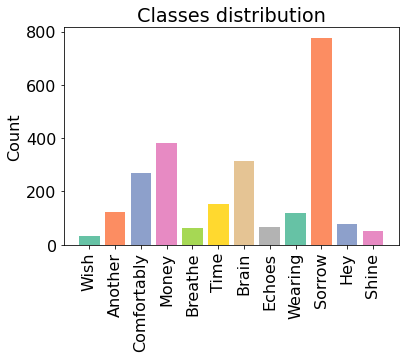

In [111]:
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

# Vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [112]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y)))
print(class_weights, '\n')

# Convert the sparse labels to categorical values
y = tfk.utils.to_categorical(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

{0: 5.953431372549019, 1: 1.6456639566395663, 2: 0.7496913580246913, 3: 0.5312773403324584, 4: 3.264784946236559, 5: 1.3229847494553377, 6: 0.6466986155484558, 7: 2.9767156862745097, 8: 1.6868055555555554, 9: 0.2605105105105105, 10: 2.628787878787879, 11: 3.968954248366013} 

(1943, 36, 6) (1943, 12)
(486, 36, 6) (486, 12)


#### Metadata

In [113]:
input_shape = X_train.shape[1:]
n_timestamps, n_features = input_shape
classes = y_train.shape[-1]

# For training
batch_size = 512
epochs = 1000

# Define the scaler we intend to use
scaler = StandardScaler()

# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

#### Data scaling

In [114]:
def scale(X_train, X_test, scaler):
    n_instances_train = X_train.shape[0]
    X_train = np.reshape(X_train, newshape=(-1, n_features))
    X_train = scaler.fit_transform(X_train)
    X_train = np.reshape(X_train, newshape=(n_instances_train, n_timestamps, n_features))
    
    if X_test is not None:
        n_instances_test = X_test.shape[0]
        X_test = np.reshape(X_test, newshape=(-1, n_features))
        X_test = scaler.transform(X_test)
        X_test = np.reshape(X_test, newshape=(n_instances_test, n_timestamps, n_features))

scaling = True

if scaling:
    scale(X_train, X_test, scaler)

#### Data reshaping

In [115]:
reshaping = False

if reshaping:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, X_train.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, X_test.shape[2]))
    input_shape = X_train.shape[1:]

#### Support functions

In [116]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None)
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Classifier

In [117]:
# we advice to choose what parameters to change and include them directly among the attributes of this function
def build_TS_classifier(input_shape, classes):
    
    input_layer = tfkl.Input(shape=input_shape)
    
    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(input_layer)
    
    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    #x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 512,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    #x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu'
        )(x)
    
    x = tfkl.GlobalAveragePooling1D()(x)
    
    x = tfkl.Dropout(0.2, seed=seed)(x)
    
    # Classifier
    x = tfkl.Dense(
        units = 256,  
        activation = 'relu'
        )(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu'
        )(x)
    
    x = tfkl.Dense(
        units = 128,  
        activation = 'relu'
        )(x)
    
    x = tfkl.Dropout(0.5, seed=seed)(x)

    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [118]:
cross_val = True
final_train = True

if cross_val:
    best_acc = 0
    best_model = None
    best_history =  []
    
    # grid search FORs go here (remember to indent the following code: SEE THEN)
    #print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° MODEL {i} °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
    
    print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° START °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')

    acc_per_fold = []
    fold_no = 1
    for train, test in kfold.split(X, y):
        print(f'Training for fold {fold_no} ...', end=' ')

        # Intantiate a new model
        model = build_TS_classifier(input_shape, classes)
        
        # Apply scaling
        X_train = np.copy(X[train])
        y_train = np.copy(y[train])
        X_test = np.copy(X[test])
        y_test = np.copy(y[test])
        scale(X_train, X_test, scaler)

        history = model.fit(X_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (X_test, y_test),
                  #class_weight = class_weights,
                  verbose = 0,
                  callbacks = [
                      tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=51, restore_best_weights=True),
                      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=tf.math.exp(-0.1), min_lr=2e-5)
                  ]
        ).history

        # Generate generalization metrics
        acc = np.max(history['val_accuracy']) * 100
        print(f'score: accuracy of {acc:.3f}%')
        acc_per_fold.append(acc)

        # Increase fold number
        fold_no = fold_no + 1
        if fold_no <= num_folds + 1:
            print('------------------------------------------------------------------------')

    print('\nAverage scores for all folds:')
    acc = np.mean(acc_per_fold)
    print(f'> Accuracy: {acc} (+- {np.std(acc_per_fold)})')
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_history = history
    
    # INDENT TILL THE PREVIOUS LINE
    print('°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
              
    # Plot results
    best_model.summary()
    plot_history(best_history)

    # RETRAIN THE BEST MODEL ON THE WHOLE DATASET
    if final_train:
        
        # Apply scaling
        scale(X, None, scaler)
        
        best_model.fit(
            x = X,
            y = y,
            batch_size = batch_size,
            epochs = epochs,
            #class_weight = class_weights,
            callbacks = [
                tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=81, restore_best_weights=True),
                tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=tf.math.exp(-0.1), min_lr=2e-5)
            ]
        )
    
else:
    best_model = build_TS_classifier(input_shape, classes)
    best_model.summary()
    
    # Train the model
    best_history = best_model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=81, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=tf.math.exp(-0.1), min_lr=2e-5)
        ]
    ).history

    # Plot results
    plot_history(best_history)
    plot_cm(best_model)

°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° START °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°
Training for fold 1 ... score: accuracy of 69.96%
------------------------------------------------------------------------
Training for fold 2 ... 

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fdb3656a7a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Needed to write correct preprocessing code (meaningful only if the "final_train" flag is set,
# otherwise simply returns the scaler fit on the last fold)
print(scaler.mean_)
print(scaler.scale_)
print(scaler.var_)

In [ ]:
save = False

if save:
    best_model.save('best_model', include_optimizer=False)
    shutil.make_archive('best_model', 'zip', 'best_model')